In [1]:
# Look for possible beacons using Zeek data
from ssh2.session import Session
import socket

class SSHCommand:
    address = ""
    username = ""
    password = ""
    
    def __init__(self, address="127.0.0.1", username="none", password="none"):
        self.address = address
        self.username = username
        self.password = password
    
    def execute(self, command = ""):
        sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
        sock.connect((self.address, 22))
        session = Session()
        session.handshake(sock)
        session.userauth_password(self.username, self.password)
        channel = session.open_session()
        channel.execute(command)
        result = ""
        size, result = channel.read()
        while size > 0:
            size, data = channel.read()
            result = result + data
        channel.close()
        session.disconnect()
        return result.decode('ascii')


In [2]:
ssh = SSHCommand(address='172.16.1.17', username='admin', password='password')
result = ssh.execute('echo -e \"timestamp,dumpthis,duration,orig_bytes,resp_bytes,orig_pkts,resp_pkts\" && zcat /nsm/zeek/logs/2021-09-01//conn.* | jq -j \'select(.conn_state == \"SF\") | .[\"ts\"], \",\", .[\"duration\"], \",\", .[\"orig_bytes\"], \",\", .[\"resp_bytes\"], \",\", .[\"orig_pkts\"], \",\", .[\"resp_pkts\"], \"\n\"\' | awk -F \":\" \'{print $1,$3}\' | sed -e \'s/ /:00:00,/g\'')

In [3]:
from io import StringIO
import pandas as pd

def string_to_df(data):
    return pd.read_csv(StringIO(data), sep=",")

df = string_to_df(result)
all_pkts = df['orig_pkts'] + df['resp_pkts']
all_bytes = df['orig_bytes'] + df['resp_bytes']
#total_pkts = df.sum('all_pkts')
#print(total_pkts)
df["all_pkts"] = all_pkts
df["all_bytes"] = all_bytes
df

,timestamp,dumpthis,duration,orig_bytes,resp_bytes,orig_pkts,resp_pkts,all_pkts,all_bytes


<AxesSubplot:xlabel='timestamp'>

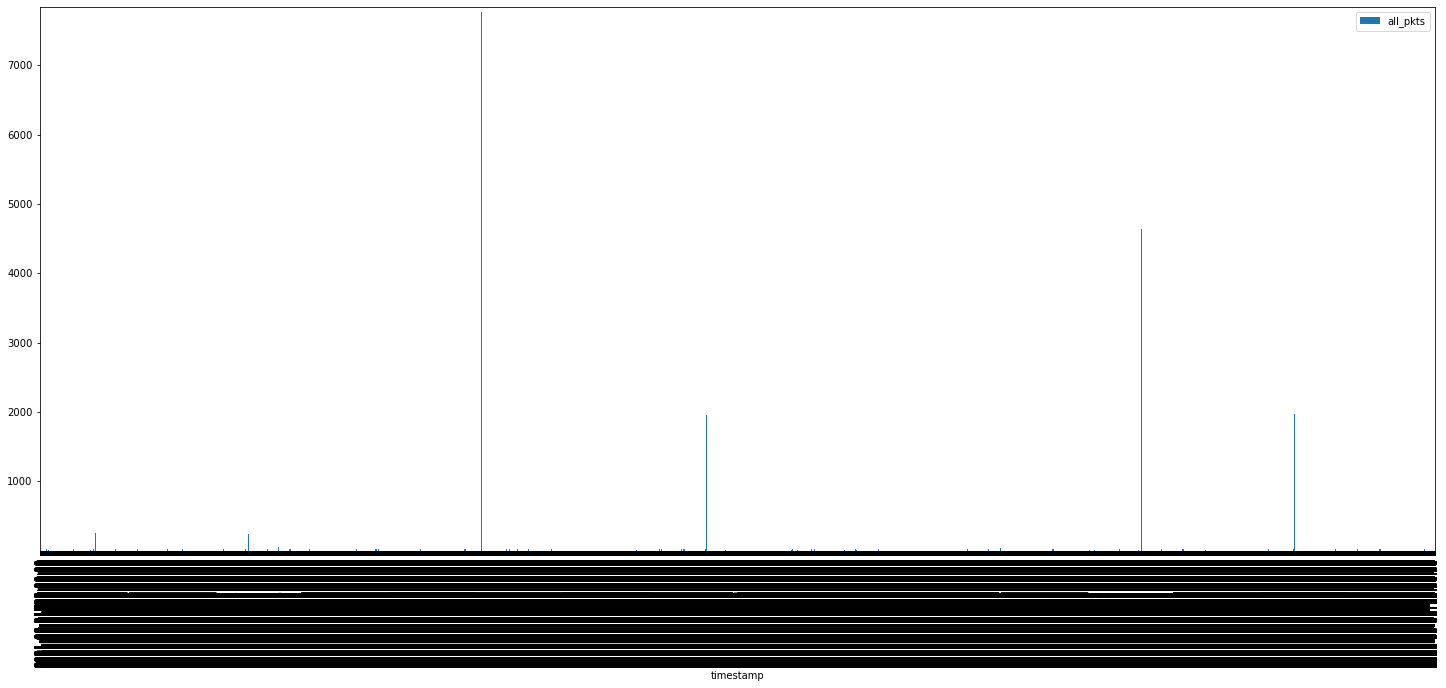

In [34]:
MAX_Y =  (df.loc[:, 'all_pkts']).max()
df.plot(x="timestamp", y="all_pkts", kind="bar", figsize=(25,10), ylim=(0.1,MAX_Y))

<AxesSubplot:xlabel='timestamp', ylabel='all_bytes'>

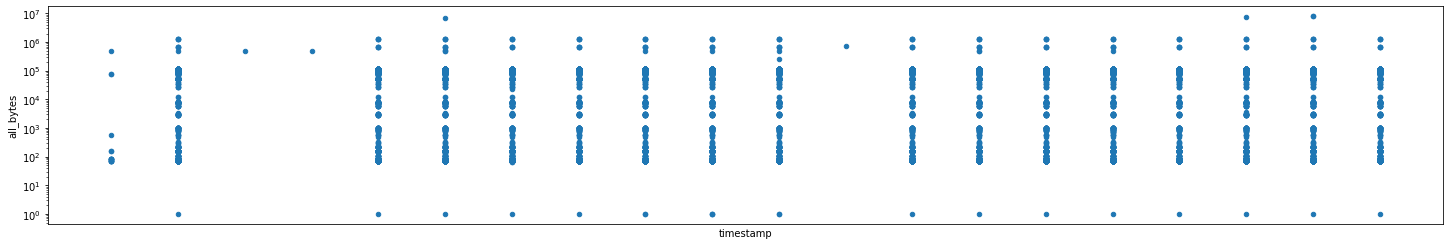

In [35]:
df.plot(x="timestamp", y="all_bytes", kind="scatter", logy=True, use_index=False, xticks=[], figsize=(25,4))

<AxesSubplot:xlabel='timestamp', ylabel='all_bytes'>

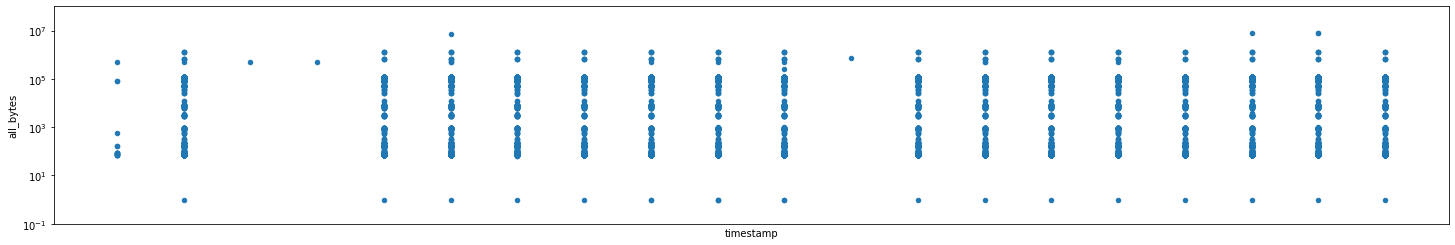

In [36]:
df.plot(x="timestamp", y="all_bytes", kind="scatter", logy=True, use_index=False, xticks=[], figsize=(25,4), ylim=(0.1,1*100000000))

<AxesSubplot:xlabel='timestamp', ylabel='all_bytes'>

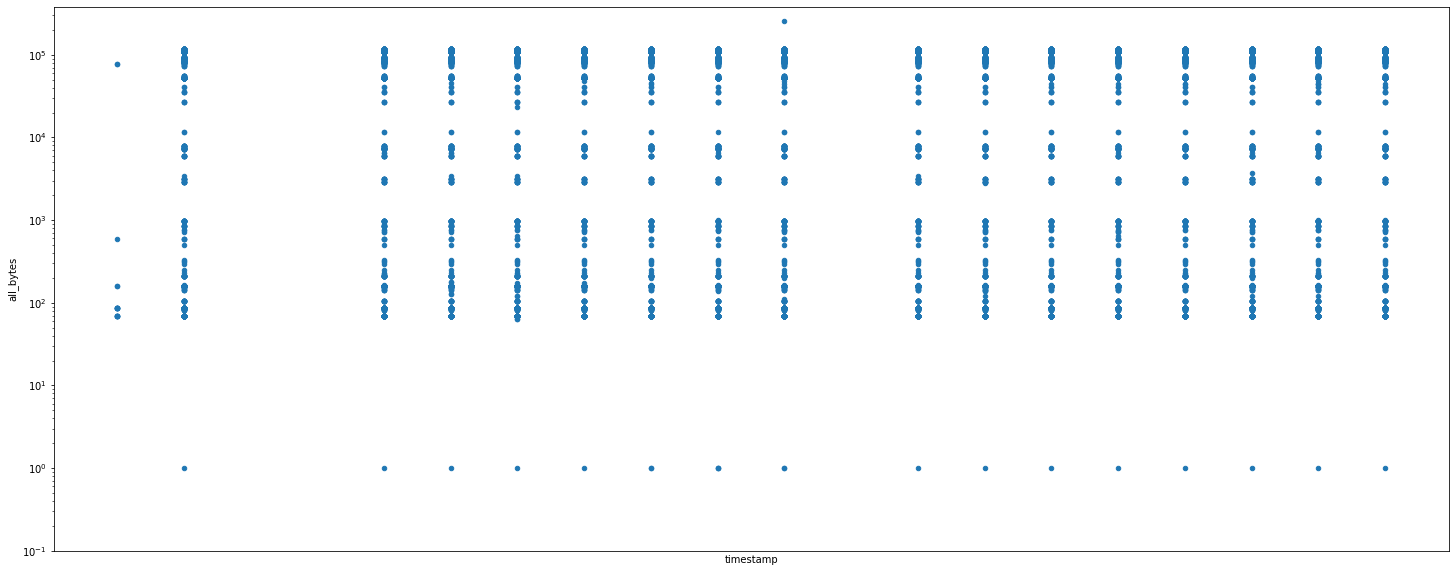

In [37]:
MAX_Y =  (df.loc[:, 'orig_bytes']).max()
df.plot(x="timestamp", y="all_bytes", kind="scatter", logy=True, use_index=False, xticks=[], figsize=(25,10), ylim=(0.1,MAX_Y))

In [38]:
import numpy as np
packets = df.loc[:, 'all_bytes']
print(packets)
np.isnan(packets)

0        585.0
1         86.0
2         86.0
3         70.0
4         70.0
         ...  
82803     70.0
82804     86.0
82805     70.0
82806     70.0
82807     86.0
Name: all_bytes, Length: 82808, dtype: float64


0        False
1        False
2        False
3        False
4        False
         ...  
82803    False
82804    False
82805    False
82806    False
82807    False
Name: all_bytes, Length: 82808, dtype: bool

In [39]:
fft = np.fft.rfft(all_pkts)
np.isnan(all_pkts)
fft

array([952570.            +0.j        ,   4991.15884276 -2217.53610486j,
         2493.25155629 -9975.12204457j, ...,
        46239.44370124-38048.09389231j, -53672.66777354-80362.18881396j,
       -72008.            +0.j        ])

C:\Users\Venator\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


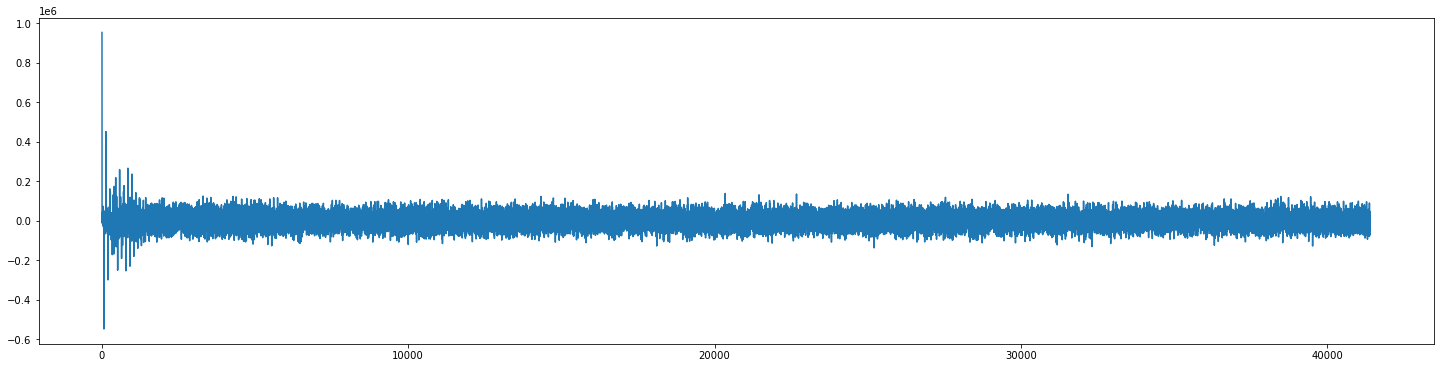

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(25,6))
plt.plot(fft)
plt.show()